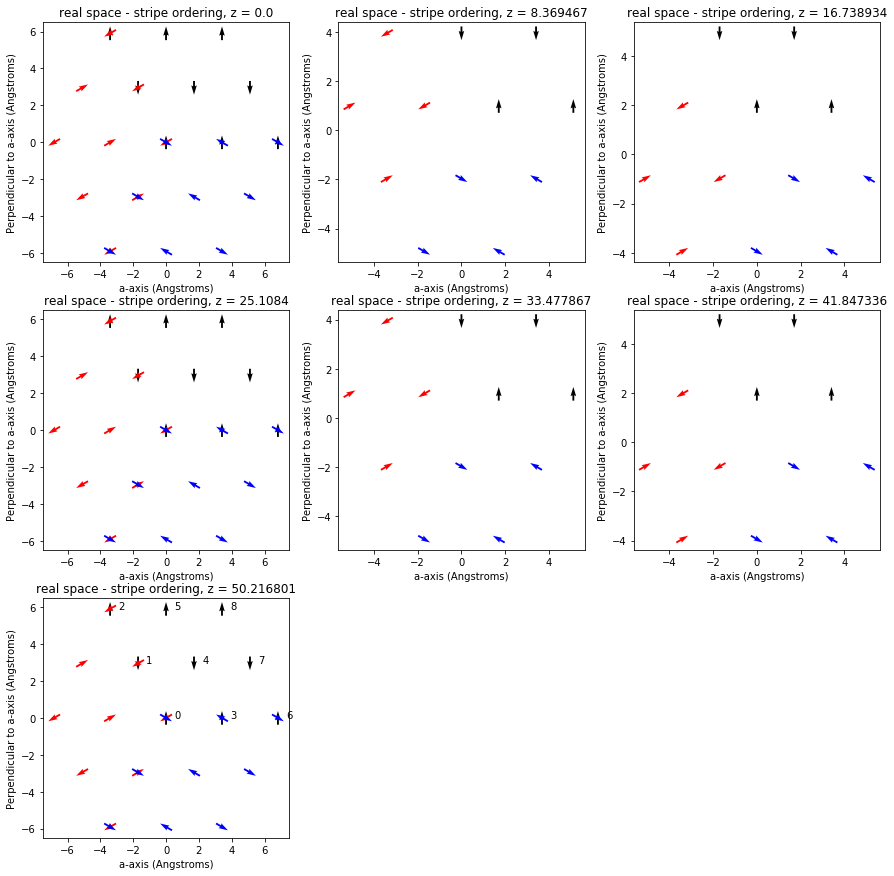

In [1]:
# August 7th 2018
# Define magnetic lattice positions
# Define spins at each [Sx,Sy,Sz] with magnitude 1, cause why not

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys,os,glob
import matplotlib.pyplot as plt
from matplotlib import colors,ticker,cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

Yb_xyz = np.loadtxt('8unitcells.xyz',skiprows=2,usecols=(1,2,3))
#Yb_xyz = Yb_xyz[Yb_xyz[:,0].argsort()]
#Yb_xyz = Yb_xyz[Yb_xyz[:,1].argsort()]
Yb_xyz_sorted = Yb_xyz[Yb_xyz[:,2].argsort()]

# Need to address each layer individually - first determine the Z-coordinates of each layer
layersZ = []
layersZ.append(Yb_xyz_sorted[0,2])
for each in Yb_xyz_sorted[:,2]:
    if each not in layersZ:
        layersZ.append(each)
# Make list of numpy arrays of coordinates for each layer
latticeByLayer = [[],[],[],[],[],[],[]]
for l in range(len(layersZ)):
    for i in range(len(Yb_xyz)):
        if Yb_xyz[i,2] == layersZ[l]:
            latticeByLayer[l].append(Yb_xyz[i])
    latticeByLayer[l] = np.array(latticeByLayer[l])

theta120 = np.radians(120)
theta240 = np.radians(240)
cos120, sin120 = np.cos(theta120), np.sin(theta120)
cos240, sin240 = np.cos(theta240), np.sin(theta240)
rot120 = np.array([[cos120, -sin120, 0],[sin120, cos120, 0],[0, 0, 1]])
rot240 = np.array([[cos240, -sin240, 0],[sin240, cos240, 0],[0, 0, 1]])
    
spinLattice = [[],[],[],[],[],[],[]]
spinLattice120 = [[],[],[],[],[],[],[]]
spinLattice240 = [[],[],[],[],[],[],[]]
for l in range(len(latticeByLayer)):
    for i in range(len(latticeByLayer[l])):
        if np.mod(l,3) == 0:
            spinLattice[l].append(np.hstack((latticeByLayer[l][i],[0,(-1)**np.mod(i,3),0])))
            spinLattice120[l].append(np.hstack((np.dot(rot120,latticeByLayer[l][i]),np.dot(rot120,[0,(-1)**np.mod(i,3),0]))))
            spinLattice240[l].append(np.hstack((np.dot(rot240,latticeByLayer[l][i]),np.dot(rot240,[0,(-1)**np.mod(i,3),0]))))
        else:
            spinLattice[l].append(np.hstack((latticeByLayer[l][i],[0,(-1)**np.mod(i,2),0])))
            spinLattice120[l].append(np.hstack((np.dot(rot120,latticeByLayer[l][i]),np.dot(rot120,[0,(-1)**np.mod(i,2),0]))))
            spinLattice240[l].append(np.hstack((np.dot(rot240,latticeByLayer[l][i]),np.dot(rot240,[0,(-1)**np.mod(i,2),0]))))
    spinLattice[l] = np.array(spinLattice[l])
    spinLattice120[l] = np.array(spinLattice120[l])
    spinLattice240[l] = np.array(spinLattice240[l])

fig = plt.figure()
for l in range(len(spinLattice)):
    plt.subplot(3,3,l+1)
    plt.quiver(spinLattice[l][:,0],spinLattice[l][:,1],spinLattice[l][:,3],spinLattice[l][:,4],pivot = 'middle')
    plt.quiver(spinLattice120[l][:,0],spinLattice120[l][:,1],spinLattice120[l][:,3],spinLattice120[l][:,4],pivot = 'middle',color = 'red')
    plt.quiver(spinLattice240[l][:,0],spinLattice240[l][:,1],spinLattice240[l][:,3],spinLattice240[l][:,4],pivot = 'middle',color = 'blue')
    plt.title('real space - stripe ordering, z = '+str(layersZ[l]))
    plt.xlabel('a-axis (Angstroms)')
    plt.ylabel('Perpendicular to a-axis (Angstroms)')
for i in range(len(spinLattice[0])):
    plt.text(spinLattice[0][i,0]+0.5,spinLattice[l][i,1],str(i))
plt.show()

$$\mathbf{M}(\mathbf{Q})=\sum_{ij} \mathbf{m}_{ij} f(\mathbf{Q}) e^{(i \mathbf{Q} \cdot \mathbf{R}_i)}$$
So first calculate 
$$\mathbf{m}_{ij} f(\mathbf{Q}) e^{(i \mathbf{Q} \cdot \mathbf{R}_i)}$$
for each lattice site and then sum.

Then, $$\frac{d\sigma}{d\Omega} \propto \mathbf{M_\perp^*} \mathbf{M_\perp} $$

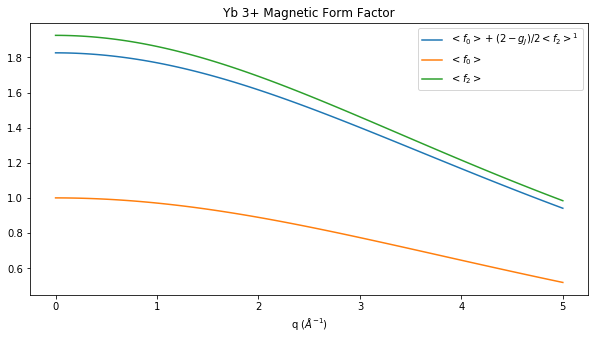

In [10]:
rcParams['figure.figsize'] = 10, 5
def getQfromHKL(h,k,l):
    a = 3.42*np.array([1,0,0])
    c = 25.12*np.array([0,0,1])
    b = 3.42*np.array([-1./2.,np.sqrt(3)/2,0])
    vol = np.dot(a,np.cross(b,c))
    astar = 2*np.pi*np.cross(b,c)/vol
    bstar = 2*np.pi*np.cross(c,a)/vol
    cstar = 2*np.pi*np.cross(a,b)/vol
    return np.array(h*astar+k*bstar+l*cstar)

# Calculate the magnetic form factor


def get_dM_of_Q(qx,qy,qz,sx,sy,sz,Rx,Ry,Rz):
    q = np.array([qx,qy,qz])
    qMagnitude = (q**2).sum()**0.5
    qhat = q/qMagnitude
    s = qMagnitude/(4*np.pi)
    mff0 = 0.0416*np.exp(-16.0949*s**2)+0.2849*np.exp(-7.8341*s**2)+0.6961*np.exp(-2.6725*s**2)-0.0219
    mff2 = 0.1570*np.exp(-18.5553*s**2)+0.8484*np.exp(-6.5403*s**2)+0.8880*np.exp(-2.0367*s**2)+0.0318
    mff = mff0 + (2-8.0/7.0)/2.0*mff2
    dM = mff*np.array([sx,sy,sz])*np.exp(1j*np.dot([qx,qy,qz],[Rx,Ry,Rz]))
    dMperp = dM-np.dot([qx,qy,qz],dM)*qhat
    return dMperp

fig = plt.figure()
def getmff(q):
    s = q/(4*np.pi) # q here is |q|
    mff0 = 0.0416*np.exp(-16.0949*s**2)+0.2849*np.exp(-7.8341*s**2)+0.6961*np.exp(-2.6725*s**2)-0.0219
    mff2 = 0.1570*np.exp(-18.5553*s**2)+0.8484*np.exp(-6.5403*s**2)+0.8880*np.exp(-2.0367*s**2)+0.0318
    mff = mff0 + (2-8.0/7.0)/2.0*mff2
    return mff, mff0, mff2
q = np.linspace(0,5,100)
mff, mff0, mff2= getmff(q)
plt.title('Yb 3+ Magnetic Form Factor')
plt.xlabel('q ($\AA^{-1}$)')
plt.plot(q,mff,label = '$<f_0> + (2-g_J)/2 <f_2>^1$')
plt.plot(q,mff0, label = '$<f_0>$')
plt.plot(q,mff2, label = '$<f_2>$')
plt.legend()
plt.show()
# This function may need to be adjusted to compute results for Q in reciprocal lattice units, as right now it is inverse angstroms

In [3]:
a = 3.42*np.array([1,0,0])
c = 25.12*np.array([0,0,1])
b = 3.42*np.array([-1./2.,np.sqrt(3)/2,0])
vol = np.dot(a,np.cross(b,c))
astar = 2*np.pi*np.cross(b,c)/vol
bstar = 2*np.pi*np.cross(c,a)/vol
cstar = 2*np.pi*np.cross(a,b)/vol
HH_norm = np.linalg.norm((astar+bstar)/2)
HmH_norm = np.linalg.norm((astar-bstar)/2)

Qx,Qy = np.meshgrid(np.linspace(-2,2,21),np.linspace(-2,2,21))
HH = (Qx+Qy)/4#/HH_norm
HmH = (Qx-Qy)/4#/HmH_norm

In [4]:
Qx,Qy,Qz = np.meshgrid(np.linspace(-1,1,21),np.linspace(-1,1,21),np.linspace(-2,2,41))
intensities = np.empty((np.shape(Qx)))
intensities120 = np.empty((np.shape(Qx)))
intensities240 = np.empty((np.shape(Qx)))

for i in range(len(Qx)):
    for j in range(len(Qy)):
        for k in range(len(Qz)):
            totalM = 0
            totalM120 = 0
            totalM240 = 0
            [qx,qy,qz] = getQfromHKL(Qx[i][j][k],Qy[i][j][k],Qz[i][j][k])
            for layer in spinLattice:
                for spin in layer:
                    totalM = totalM + get_dM_of_Q(qx,qy,qz,spin[3],spin[4],spin[5],spin[0],spin[1],spin[2])
            for layer in spinLattice120: 
                for spin in layer:
                    totalM120 = totalM120 + get_dM_of_Q(qx,qy,qz,spin[3],spin[4],spin[5],spin[0],spin[1],spin[2])
            for layer in spinLattice240:
                for spin in layer:
                    totalM240 = totalM240 + get_dM_of_Q(qx,qy,qz,spin[3],spin[4],spin[5],spin[0],spin[1],spin[2])
            intensities[i][j][k]=np.vdot(totalM,totalM)
            intensities120[i][j][k]=np.vdot(totalM120,totalM120)
            intensities240[i][j][k]=np.vdot(totalM240,totalM240)




C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Will\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


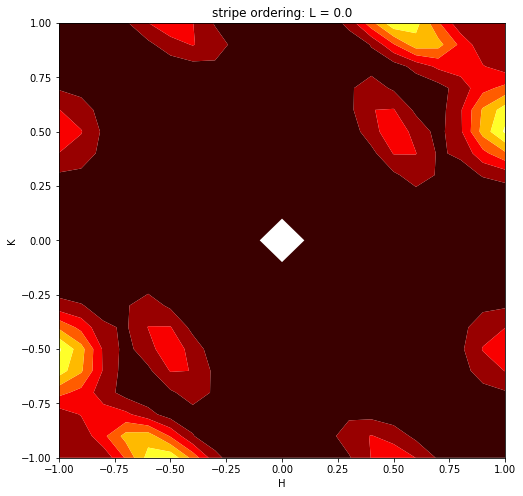

In [11]:
rcParams['figure.figsize'] = 8, 8
QzIndex = 20
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
intensitiesAll = intensities+intensities120+intensities240
q = ax3.contourf(Qx[:,:,QzIndex],Qy[:,:,QzIndex],intensitiesAll[:,:,QzIndex],cmap='hot',antialiased=True)
ax3.set_xlim(-1,1),
ax3.set_ylim(-1,1)
plt.title('stripe ordering: L = '+str(Qz[:,:,QzIndex][0][0]))
plt.xlabel('H')
plt.ylabel('K')
plt.show()

0.0


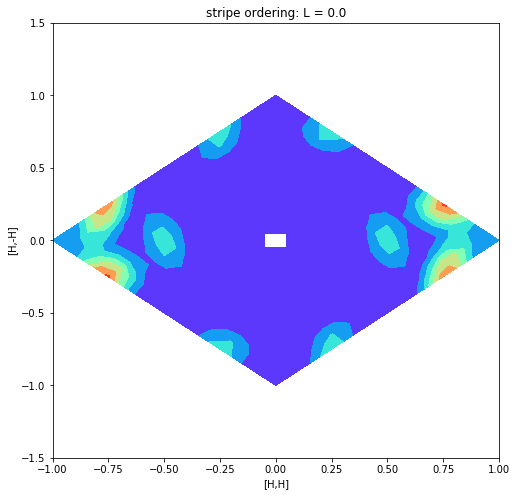

In [7]:
# View the scattering in 'natural' hexagonal coordinates

HH = (Qx+Qy)/2#/HH_norm
HmH = (Qx-Qy)/2#/HmH_norm

QzIndex = 20
print(Qz[:,:,QzIndex][0][0])

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)

q = ax3.contourf(HH[:,:,QzIndex],HmH[:,:,QzIndex],intensitiesAll[:,:,QzIndex],cmap='rainbow',antialiased=False)
plt.xlim([-1,1])
plt.ylim([-1.5,1.5])
plt.title('stripe ordering: L = '+str(Qz[:,:,QzIndex][0][0]))
plt.xlabel('[H,H]')
plt.ylabel('[H,-H]')
plt.show()